# Evaluación del caso “Kicked Kepler con impulsos periódicos”

Analizamos un sistema Kepleriano perturbado: una estrella central y una partícula ligera que recibe impulsos periódicos en velocidad. El objetivo es encontrar masas dentro de rangos estrechos que mitiguen la respuesta caótica y favorezcan órbitas cuasi periódicas pese a las perturbaciones.

> **Interpretación**
> - La métrica de Lyapunov indica qué tan sensible es la órbita ante el “kick” periódico; valores más bajos implican trayectorias controladas.
> - La penalización de periodicidad ayuda a que el estado tras cada ciclo completo de impulsos permanezca próximo al inicial.


## Preparación del entorno

Localizamos la carpeta raíz `two_body`, la añadimos a `sys.path` y definimos `PARENT` para acceder a utilidades compartidas. Así evitamos problemas de importación sin importar dónde se ejecute el notebook.


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

if PROJECT_ROOT.name != "two_body":
    raise RuntimeError("No se encontró la carpeta two_body")

PARENT = PROJECT_ROOT.parent  # directorio que contiene a two_body
if str(PARENT) not in sys.path:
    sys.path.insert(0, str(PARENT))

print("PYTHONPATH += ", PARENT)


PYTHONPATH +=  C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies


## Dependencias clave del pipeline

Importamos la configuración (`Config`), el controlador híbrido, los visualizadores 2D/3D, el adaptador REBOUND base y utilidades como `numpy` y `Path` para manejar resultados y artefactos.


In [2]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer as PlanarVisualizer
from two_body.presentation.triDTry import Visualizer as Visualizer3D
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np
from pathlib import Path  # si quieres guardar animaciones/figuras


## Instrumentación de rendimiento

Activamos `PERF_TIMINGS_ENABLED` y cargamos las herramientas de la suite de tiempos (`time_block`, `latest_timing_csv`, etc.). Esto permitirá inspeccionar los costos de cada fase del experimento Kicked Kepler.


In [3]:
import os
os.environ["PERF_TIMINGS_ENABLED"] = "1"
os.environ.setdefault("PERF_TIMINGS_JSONL", "0")

from two_body.perf_timings.timers import time_block
from two_body.perf_timings import latest_timing_csv, read_timings_csv, parse_sections_arg, filter_rows


## Formato de logging amigable en notebook

Creamos un `NotebookHandler` que acumula los mensajes del optimizador y los imprime progresivamente. Mantiene el contexto de ejecución visible sin saturar la salida con trazas crudas.


In [4]:
import logging
from IPython.display import display, Markdown

class NotebookHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.lines = []

    def emit(self, record):
        msg = self.format(record)
        self.lines.append(msg)
        print(msg)  # aparece en la celda conforme avanza

handler = NotebookHandler()
handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s"))

logger = setup_logger(level="INFO")
logger.handlers.clear()          # quita otros handlers previos
logger.addHandler(handler)
logger.setLevel(logging.INFO)


## Configuración del escenario “Kicked Kepler” físico

Trabajamos en unidades astronómicas reales (UA, años, masas solares):
- Órbita casi circular para un planeta tipo Tierra alrededor de una estrella ~1 Msun.
- Impulsos periódicos pequeños (`kick_period`, `kick_delta_v`) que simulan maniobras tangenciales.
- Presupuestos moderados del GA para iteraciones rápidas.


In [5]:
# Kicked Kepler (unidades físicas)
case = {
    # Integración (UA, años, masas solares)
    "t_end_short": 0.5,            # ~3 impulsos, sirve para iterar rápido
    "t_end_long": 4.0,             # verificación a 2.5 años
    "dt": 2.0e-4,                  # ≈0.18 días; estable con IAS15
    "integrator": "ias15",

    # Estado inicial: estrella ~1 Msun en reposo y planeta tipo Tierra a 1 UA
    "r0": (
        (0.0, 0.0, 0.0),           # estrella central
        (1.0, 0.0, 0.0),           # planeta en el eje X
    ),
    "v0": (
        (0.0, 0.0, 0.0),           # estrella fija (masa dominante)
        (0.0, 6.2831853072, 0.0),  # velocidad circular ≈2π UA/año
    ),

    # Parámetros físicos
    "mass_bounds": (
        (0.8, 1.2),              # estrella cerca de 1 Msun
        (2.8e-6, 3.4e-2),          # planeta tipo Tierra (≈3e-6 Msun)
    ),
    "G": 39.47841760435743,        # 4π² en UA^3 / (Msun·año²)
    "periodicity_weight": 0.05,    # penaliza deriva moderada Δr + Δv

    # Impulso periódico (“kick”)
    "kick_period": 0.25,           # cada 0.25 años (~91 días)
    "kick_delta_v": (0.0, 0.05, 0.0),  # refuerzo tangencial ~0.24 km/s
    "kick_target": 1,              # aplica el impulso al planeta

    # GA / búsqueda continua (prueba relativamente breve)
    "pop_size": 180,
    "n_gen_step": 5,
    "mutation": 0.2,
    "crossover": 0.85,
    "elitism": 2,
    "seed": 314159,

    # Control de ejecución
    "max_epochs": 50,
    "top_k_long": 12,
    "stagnation_window": 5,
    "stagnation_tol": 1.25e-4,
    "local_radius": 0.04,
    "radius_decay": 0.85,
    "time_budget_s": 1800.0,
    "eval_budget": 16000,

    # Artefactos / salida
    "artifacts_dir": "artifacts/kicked_kepler_real",
    "save_plots": True,
    "headless": False,
}


In [6]:

from two_body.logic.controller import ContinuousOptimizationController
from two_body.core.config import Config
from two_body.core.telemetry import setup_logger
from two_body.core.cache import HierarchicalCache

_kick_keys = (
    "kick_period",
    "kick_delta_v",
    "kick_target",
)
config_kwargs = {k: v for k, v in case.items() if k not in _kick_keys}

cfg = Config(**config_kwargs)
set_global_seeds(cfg.seed)
logger = setup_logger()


## Adaptador REBOUND con impulsos periódicos

Subclasamos `ReboundSim` para construir `KickedKeplerSim`, que aplica un incremento de velocidad `Δv` al cuerpo objetivo cada `kick_period`. Registramos la función en `post_timestep_modifications` y monkeypatcheamos el módulo `rebound_adapter` para que el resto del pipeline use este integrador “pateado”.


In [7]:
from two_body.simulation.rebound_adapter import ReboundSim as _BaseReboundSim
kick_period = case["kick_period"]
kick_delta_v = case["kick_delta_v"]
kick_target = case["kick_target"]

class KickedKeplerSim(_BaseReboundSim):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._kick_period = kick_period
        self._kick_delta_v = kick_delta_v
        self._kick_target = kick_target

    def setup_simulation(self, *args, **kwargs):
        sim = super().setup_simulation(*args, **kwargs)
        next_kick = {"t": sim.t + self._kick_period}
        dv = self._kick_delta_v

        def apply_kick(_ptr=None):
            while sim.t >= next_kick["t"] - 1e-12:
                p = sim.particles[self._kick_target]
                p.vx += dv[0]
                p.vy += dv[1]
                p.vz += dv[2]
                next_kick["t"] += self._kick_period

        sim.post_timestep_modifications = apply_kick
        return sim

# Monkeypatch para que todo el pipeline use el adaptador pateado
from two_body.simulation import rebound_adapter
rebound_adapter.ReboundSim = KickedKeplerSim

In [8]:

from two_body.simulation.lyapunov import LyapunovEstimator

masses = tuple(np.mean(bounds) for bounds in cfg.mass_bounds)
sim = ReboundSim(G=cfg.G, integrator=cfg.integrator).setup_simulation(
    masses,
    cfg.r0[: len(masses)],
    cfg.v0[: len(masses)],
)
estimator = LyapunovEstimator()
ret = estimator.mLCE({"sim": sim, "dt": cfg.dt, "t_end": cfg.t_end_short, "masses": masses})
print(ret)


{'lambda': 5.617102963610244, 'series': None, 'meta': {'steps': 2500, 'dt': 0.0002, 'n_bodies': 2, 'masses': (1.0, 0.0170014), 'impl': 'rebound_megno'}}


c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [9]:
print(cfg.mass_bounds, cfg.max_epochs, cfg.eval_budget)

((0.8, 1.2), (2.8e-06, 0.034)) 50 16000


## Ejecución del controlador híbrido

Instanciamos `Config`, el `logger` y el `ContinuousOptimizationController`. Envolvemos `controller.run()` dentro de `time_block("notebook_run")` para medir la ejecución completa (GA + refinamiento continuo) bajo el régimen de impulsos periódicos.


In [10]:
with time_block("notebook_run", extra={"source": "Caso03.ipynb"}):
    controller = ContinuousOptimizationController(cfg, logger=logger)
    results = controller.run()

[2025-11-02 18:03:24,171] INFO - Starting optimization | pop=180 | dims=2 | time_budget=1800.0s | eval_budget=16000
[2025-11-02 18:03:34,260] INFO - Epoch 0 | new global best (short) lambda=-0.608653 | fitness=-0.130490 | penalty=14.782862 | masses=(1.076408, 0.009538)
[2025-11-02 18:03:39,255] INFO - Epoch 0 | new global best (long) lambda=0.078349 | fitness=-0.112894 | penalty=0.690898 | masses=(1.112924, 0.018475)
[2025-11-02 18:03:39,255] INFO - Epoch 0 complete | lambda_short=-0.608653 | fitness_short=-0.130490 | lambda_best=0.078349 | fitness_best=-0.112894 | evals short/long=180/12 | total evals=192 | radius=0.0400
[2025-11-02 18:03:49,009] INFO - Epoch 1 | new global best (short) lambda=-1.175435 | fitness=0.522169 | penalty=13.065319 | masses=(0.893851, 0.005434)
[2025-11-02 18:03:54,206] INFO - Epoch 1 complete | lambda_short=-1.175435 | fitness_short=0.522169 | lambda_best=-1.175435 | fitness_best=0.522169 | evals short/long=180/12 | total evals=384 | radius=0.0400
[2025-11-

## Métricas de referencia y solución óptima

Calculamos el fitness del punto central de los rangos de masa (`center`) y lo comparamos con `results["best"]`. Obtenemos `baseline_details` para revisar cómo afectan los kicks al exponente de Lyapunov y conservamos `metrics` para graficar la evolución de λ y del fitness.


In [11]:
metrics = controller.metrics
results

{'status': 'completed',
 'best': {'masses': [1.045258635678602, 2.8e-06],
  'lambda': -2.569736031111161,
  'fitness': 1.825860801467893,
  'm1': 1.045258635678602,
  'm2': 2.8e-06},
 'evals': 9600,
 'epochs': 50}

In [12]:

from two_body.core.cache import HierarchicalCache
from two_body.logic.fitness import FitnessEvaluator

#original_masses = tuple((lo + hi) / 2.0 for lo, hi in cfg.mass_bounds)
original_masses = (1.2, 3.3e-4)
center = original_masses

baseline_entry = ret
baseline_lambda_short = baseline_entry.get("lambda")
if baseline_lambda_short is None or not np.isfinite(baseline_lambda_short):
    baseline_lambda_short = -float(baseline_entry.get("fitness", 0.0))

best_payload = results.get("best") or {}
best_lambda_short = best_payload.get("lambda")
if best_lambda_short is None and best_payload.get("fitness") is not None:
    best_lambda_short = -float(best_payload["fitness"])

print(
    f"λ original (short) = {baseline_lambda_short:.6f}, "
    f"λ optimizado (short) = {best_lambda_short:.6f}"
    if best_lambda_short is not None
    else f"λ original (short) = {baseline_lambda_short:.6f}, λ optimizado = N/A"
)

RUN_LONG_CHECK = False
if RUN_LONG_CHECK and best_payload.get("masses"):
    evaluator = FitnessEvaluator(HierarchicalCache(), cfg)
    orig_fits, orig_details = evaluator.evaluate_batch(
        [original_masses],
        horizon="long",
        return_details=True,
    )
    opt_fits, opt_details = evaluator.evaluate_batch(
        [tuple(best_payload["masses"])],
        horizon="long",
        return_details=True,
    )
    lambda_orig_long = orig_details[0].get("lambda")
    if lambda_orig_long is None or not np.isfinite(lambda_orig_long):
        lambda_orig_long = -orig_fits[0]
    lambda_opt_long = opt_details[0].get("lambda")
    if lambda_opt_long is None or not np.isfinite(lambda_opt_long):
        lambda_opt_long = -opt_fits[0]
    print(
        f"λ original (long) = {lambda_orig_long:.6f}, "
        f"λ optimizado (long) = {lambda_opt_long:.6f}"
    )


λ original (short) = 5.617103, λ optimizado (short) = -2.569736


In [13]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
print("Trayectoria calculada con masas óptimas.")
print(traj.shape)
print(traj[-1])
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]


Trayectoria calculada con masas óptimas.
(20000, 2, 6)
[[ 1.43029738e-06 -2.05143528e-06  0.00000000e+00  1.44315179e-05
   1.08237131e-05  0.00000000e+00]
 [-5.33939533e-01  7.65814443e-01  0.00000000e+00 -5.38738169e+00
  -4.04056415e+00  0.00000000e+00]]


In [14]:
from two_body.scripts.demo_tierra import (
    summarize_trajectory,
    compute_total_energy,
    estimate_orbital_period,
)

summarize_trajectory(
    logger=logger,
    traj=traj,
    masses=best_masses,
    cfg=cfg,
)

[2025-11-02 18:17:06,527] INFO - Resumen de simulacion
[2025-11-02 18:17:06,527] INFO -   pasos=20000 | dt=0.000200 anos | duracion total=4.000 anos
[2025-11-02 18:17:06,527] INFO -   masas=(1.045258635678602, 2.8e-06) (M_sun) | G=39.478418
[2025-11-02 18:17:06,528] INFO -   centro de masa: desplazamiento maximo = 2.066e-21 UA
[2025-11-02 18:17:06,530] INFO -   cuerpo 0 -> radio[min, max]=[0.0000, 0.0000] UA | radio sigma=7.7750e-08 | velocidad media=0.0000 UA/ano
[2025-11-02 18:17:06,531] INFO -   cuerpo 1 -> radio[min, max]=[0.9170, 1.0000] UA | radio sigma=2.9024e-02 | velocidad media=6.5501 UA/ano
[2025-11-02 18:17:06,534] INFO -   energia total (media)=-6.027280e-05 | variacion relativa=1.574e-15
[2025-11-02 18:17:06,536] INFO -   periodo orbital estimado para la Tierra ~= 0.917852 anos
[2025-11-02 18:17:06,536] INFO -   error relativo vs 1 ano ~= 8.215e-02


## Visualización y seguimiento de convergencia

Mostramos:
- `plot_lambda_evolution` y `plot_fitness_evolution` para estudiar cómo responde el GA ante los impulsos repetidos.
- Las trayectorias integradas con las masas óptimas (`xyz_tracks`) tanto en vista rápida 2D (`quick_view`) como en la animación 3D final, verificando si la órbita se mantiene acotada tras sucesivos kicks.


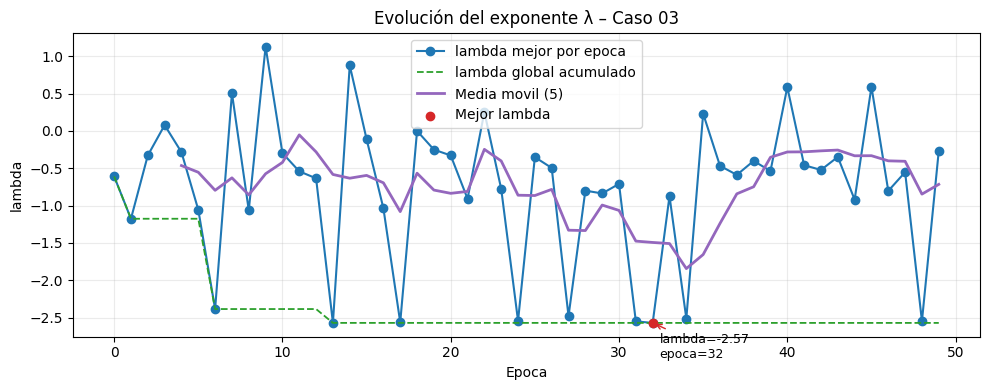

In [15]:
viz_3d = Visualizer3D(headless=cfg.headless)

_ = viz_3d.plot_lambda_evolution(
    lambda_history=metrics.best_lambda_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolución del exponente λ – Caso 03",
    moving_average_window=5,   # opcional
)

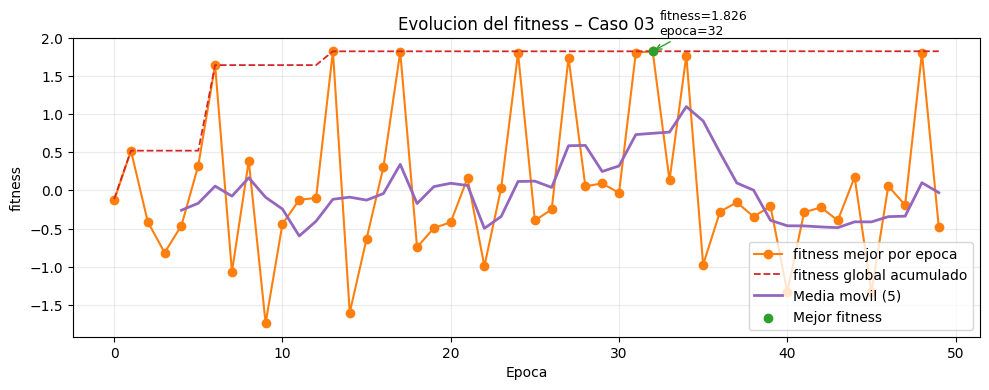

In [16]:
_ = viz_3d.plot_fitness_evolution(
    fitness_history=metrics.best_fitness_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolucion del fitness – Caso 03",
    moving_average_window=5,
)


In [17]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]

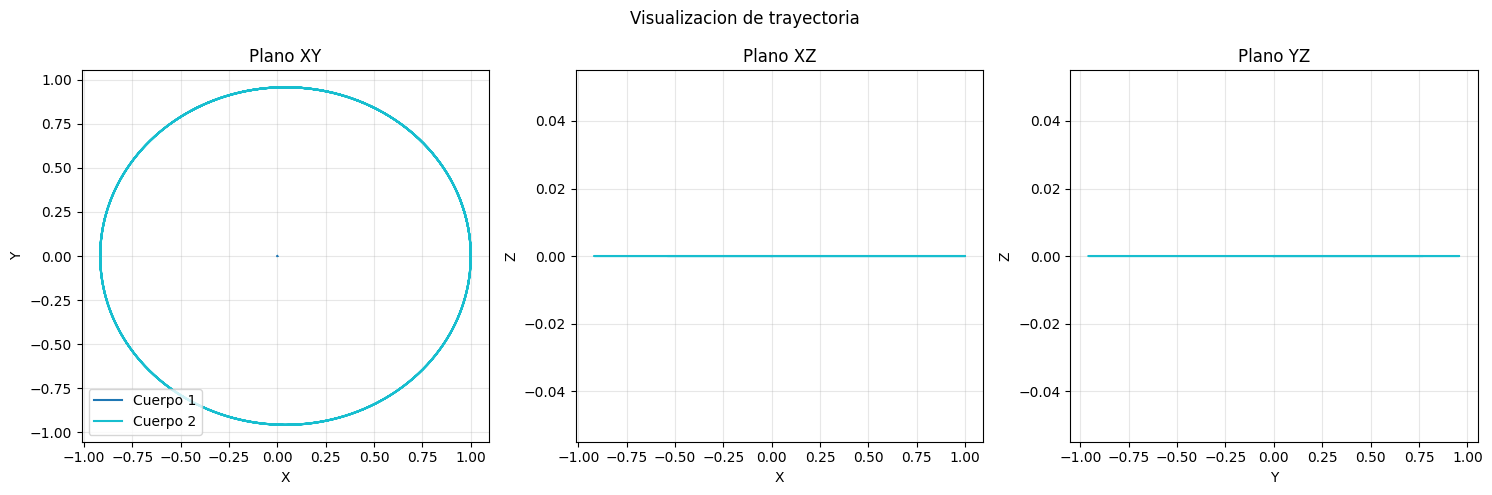

In [18]:
viz_planar = PlanarVisualizer(headless=cfg.headless)
_ = viz_planar.quick_view(xyz_tracks) 

In [19]:
from IPython.display import HTML

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 1024  # MB

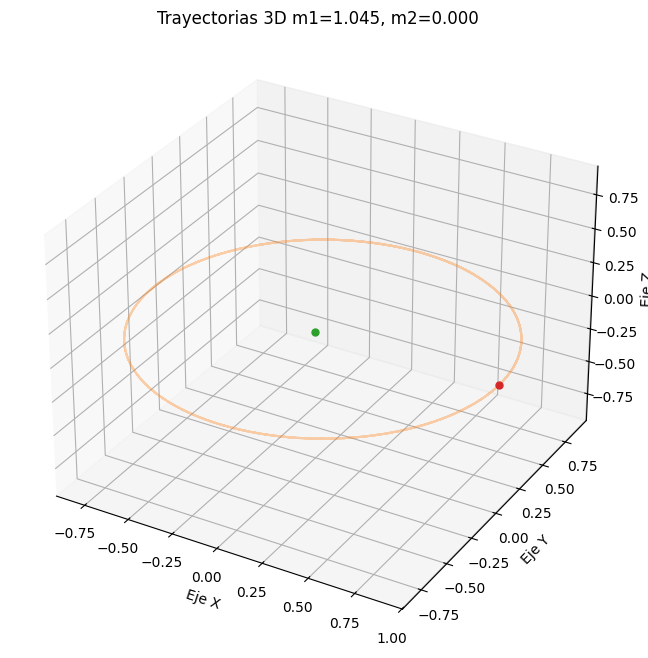

In [20]:
viz_3d = Visualizer3D(headless=False)

anim = viz_3d.animate_3d(
    trajectories=xyz_tracks,
    interval_ms=50,
    title=f"Trayectorias 3D m1={best_masses[0]:.3f}, m2={best_masses[1]:.3f}",
    total_frames=len(xyz_tracks[0]),
)
#HTML(anim.to_jshtml())  

## Exportación de animaciones

Configuramos un `FFMpegWriter`, creamos `artifacts/caso03` (ajusta la ruta si lo prefieres) y guardamos los MP4 de la trayectoria y de la comparación de masas. Puedes modificar `fps`, `bitrate` o el preset de ffmpeg si necesitas acelerar el render.


In [21]:
from matplotlib.animation import FFMpegWriter  # o PillowWriter para GIF

writer = FFMpegWriter(
    fps=20,
    bitrate=1800,
    extra_args=["-vcodec", "libx264", "-preset", "ultrafast", "-crf", "28"]
)

output_path = Path("artifacts/caso03")                # ajusta a tu gusto
output_path.mkdir(parents=True, exist_ok=True)

anim.save(output_path / "trayectoria_optima.mp4", writer=writer)

In [22]:
# Trayectoria con las masas originales (center)
sim_orig = sim_builder.setup_simulation(center, r0, v0)
traj_original = sim_builder.integrate(sim_orig, t_end=cfg.t_end_long, dt=cfg.dt)

# Si ya integraste con las masas óptimas, recicla ese resultado
traj_opt = traj  # 'traj' es la integración que acabas de calcular con best_masses


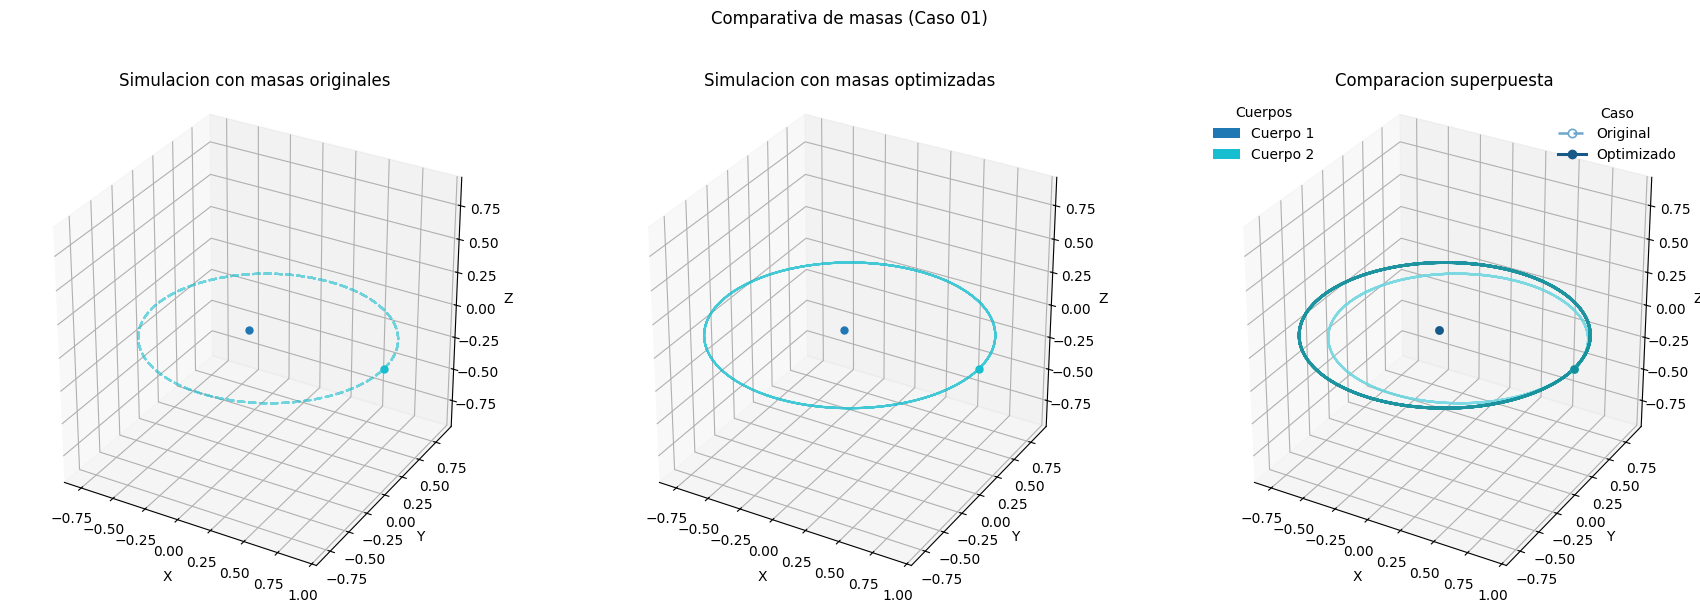

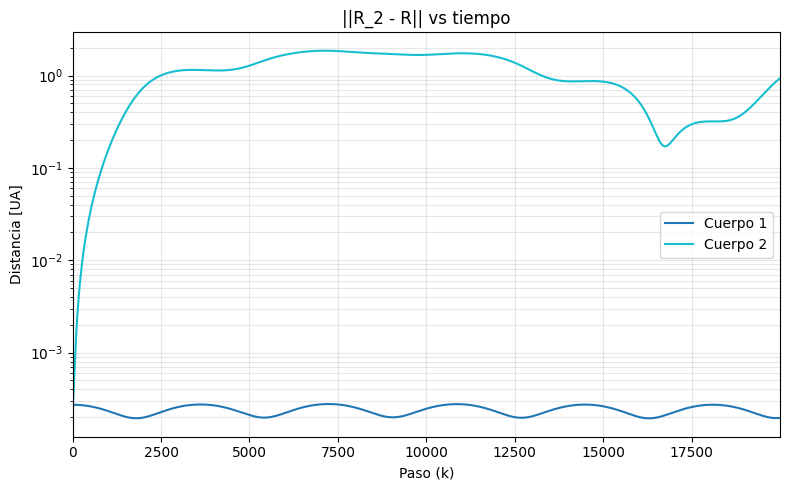

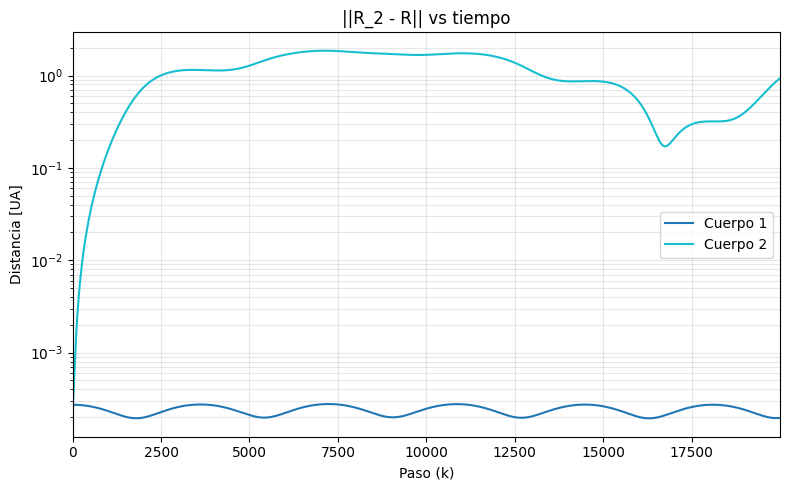

In [23]:
orig_tracks = [traj_original[:, i, :3] for i in range(traj_original.shape[1])]
opt_tracks = [traj_opt[:, i, :3] for i in range(traj_opt.shape[1])]

anim_mass = viz_3d.plot_mass_comparison(
    original_tracks=orig_tracks,
    optimized_tracks=opt_tracks,
    original_masses=center,          # opcional, útil para etiquetar/distancias
    optimized_masses=best_masses,    # idem
    body_labels=[f"Cuerpo {i+1}" for i in range(len(opt_tracks))],
    dt=cfg.dt,                       # usa tu paso real si quieres la etiqueta temporal
    title="Comparativa de masas (Caso 01)",
)

if anim_mass is not None:
    dist_fig = viz_3d.plot_mass_distance_evolution(
        comparison_data=anim_mass.mass_comparison_data,
        title="||R_2 - R|| vs tiempo",
    )
    if dist_fig is not None:
        display(dist_fig)
    # display(HTML(anim_mass.to_jshtml()))  # descomenta para ver la animación embebida


In [24]:
anim_mass.save(output_path / "comparativa_masas.mp4", writer=writer)

## Reporte de tiempos de ejecución

Leemos el CSV generado por la instrumentación, mostramos una vista preliminar y agregamos estadísticas por sección para detectar qué partes del flujo (simulación con kicks, evaluación larga, etc.) dominan el costo computacional en este caso.


In [ ]:
import pandas as pd

csv_path = latest_timing_csv()
display(f"Usando CSV: {csv_path}")

rows = read_timings_csv(csv_path)
df = pd.DataFrame(rows)
display(df.head(10))

# Estadísticas rápidas por sección
section_stats = (
    df.groupby("section")["duration_us"]
    .agg(["count", "mean", "sum"])
    .sort_values("sum", ascending=False)
)
section_stats

NameError: name 'latest_timing_csv' is not defined

In [1]:
import os
import subprocess
from pathlib import Path
from IPython.display import Image, display

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

env = os.environ.copy()
env["PYTHONPATH"] = str(PROJECT_ROOT)

run_id = df["run_id"].iloc[0]
cmd = [
    sys.executable,
    "scripts/plot_timings.py",
    "--run-id", str(run_id),
    "--top-n", "5",
]


print("Ejecutando:", " ".join(cmd))
result = subprocess.run(cmd, cwd=PROJECT_ROOT, env=env, text=True, capture_output=True)
print(result.stdout)
print(result.stderr)
result.check_returncode()

reports_dir = PROJECT_ROOT / "reports"

display(
    Image(filename=str(reports_dir / f"timeline_by_individual_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_by_batch_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_simulation_{run_id}.png")),
    Image(filename=str(reports_dir / f"pie_sections_{run_id}.png")),
)

NameError: name 'df' is not defined